# Analysis of DJA/SE++ catalogs

This notebook creates scientific plots from the merged catalogs from SourceXtractor++ (Sersic and Bulge+Disk models) and from the DJA (aperture photometry and photo-z).

In [1]:
import os
import boto3
s3 = boto3.client('s3')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from astropy.io import fits
from astropy.cosmology import WMAP9 as cosmo
from astropy.table import Table
from astropy.stats import sigma_clipped_stats
import astropy.units as u
import dja_sepp

plt.rcParams['xtick.labelsize']='large'
plt.rcParams['ytick.labelsize']='large'
plt.rcParams['axes.labelsize']='x-large'
plt.rcParams['legend.fontsize']='large'
plt.rcParams['xtick.top']=True
plt.rcParams['ytick.right']=True
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['ytick.minor.visible']=True
# %matplotlib ipympl

In [2]:
home = "/home/aurelien/DAWN/DJA-SEpp"
field = 'primer-cosmos-east-grizli-v7.0'

#### Download catalog from S3

In [3]:
cat = dja_sepp.s3.find_files(bucket='aurelien-sepp', 
                             path=f'{field}/catalog', 
                             regex=f".+morpho-phot\.fits\.gz")[0]
cat

'primer-cosmos-west-grizli-v7.0_morpho-phot.fits.gz'

In [4]:
folder = f'{home}/fields/{field}/catalog'
os.makedirs(folder, exist_ok=True)
s3.download_file('aurelien-sepp', f'{field}/catalog/{cat}', f"{folder}/{cat}")

#### Open catalog

In [45]:
with fits.open(f"{home}/fields/{field}/catalog/{field}_morpho-phot.fits") as hdul:
    tab_dja = Table(hdul[1].data)
    tab_sersic = Table(hdul[2].data)
    tab_BD = Table(hdul[3].data)

In [46]:
good = (tab_sersic['flag']==2) & (tab_BD['flag']==2)
good_dja = tab_dja[good]
good_sersic = tab_sersic[good]
good_BD = tab_BD[good]

## Morphology

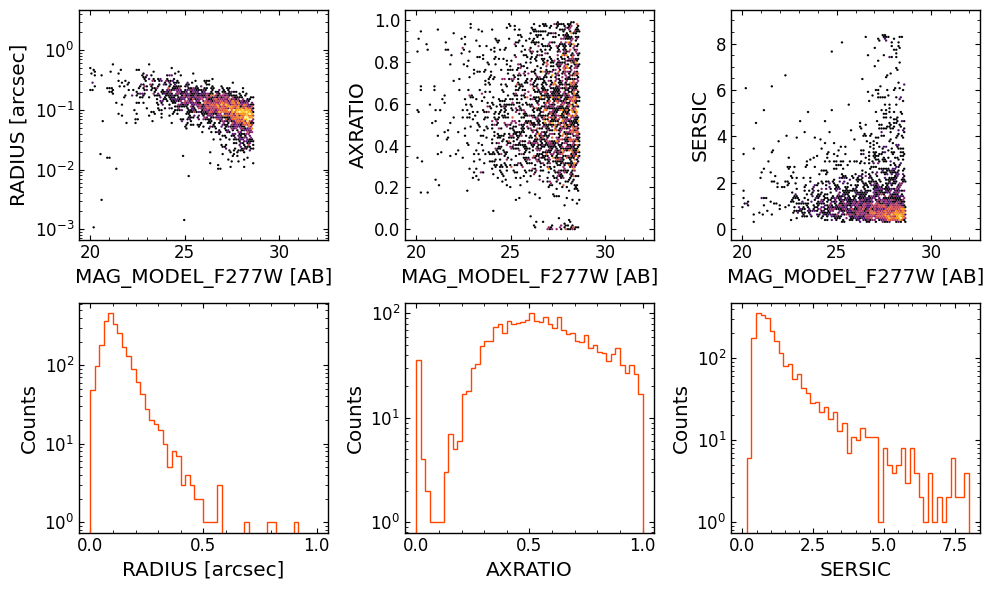

In [6]:
# sersic_rg4

plot_sersic = tab_sersic[tab_sersic['flag']==2]

filter = 'f277w'
fig, axs = plt.subplots(2,3, figsize=(10,6))

axs[0,0].hexbin(plot_sersic[f'MAG_MODEL_{filter.upper()}'], plot_sersic['RADIUS']*3600, mincnt=1, gridsize=100, cmap='inferno', bins='log', yscale='log', extent=(20,32,-3,0.5), lw=0.01)
axs[0,0].set_xlabel(f"MAG_MODEL_{filter.upper()} [AB]")
axs[0,0].set_ylabel("RADIUS [arcsec]")

axs[0,1].hexbin(plot_sersic[f'MAG_MODEL_{filter.upper()}'], plot_sersic['AXRATIO'], mincnt=1, gridsize=100, cmap='inferno', bins='log', extent=(20,32,0,1), lw=0.01)
axs[0,1].set_xlabel(f"MAG_MODEL_{filter.upper()} [AB]")
axs[0,1].set_ylabel("AXRATIO")

axs[0,2].hexbin(plot_sersic[f'MAG_MODEL_{filter.upper()}'], plot_sersic['SERSIC'], mincnt=1, gridsize=100, cmap='inferno', bins='log', extent=(20,32,0,9), lw=0.01)
axs[0,2].set_xlabel(f"MAG_MODEL_{filter.upper()} [AB]")
axs[0,2].set_ylabel("SERSIC")

axs[1,0].hist(plot_sersic['RADIUS']*3600, bins=50, range=(0,1), histtype='step', log=True, color='orangered')
axs[1,0].set_xlabel("RADIUS [arcsec]")
axs[1,0].set_ylabel("Counts")

axs[1,1].hist(plot_sersic['AXRATIO'], bins=50, range=(0,1), histtype='step', log=True, color='orangered')
axs[1,1].set_xlabel("AXRATIO")
axs[1,1].set_ylabel("Counts")

axs[1,2].hist(plot_sersic['SERSIC'], bins=50, range=(0,8), histtype='step', log=True, color='orangered')
axs[1,2].set_xlabel("SERSIC")
axs[1,2].set_ylabel("Counts")

fig.tight_layout()
# fig.savefig(f"{home}/fields/{field}/sepp/{field}-sersic_rg4_morphology.pdf", bbox_inches='tight')
# fig.savefig(f"{home}/fields/{field}/sepp/{field}-sersic_rg4_morphology.png", bbox_inches='tight', dpi=200)
plt.show()

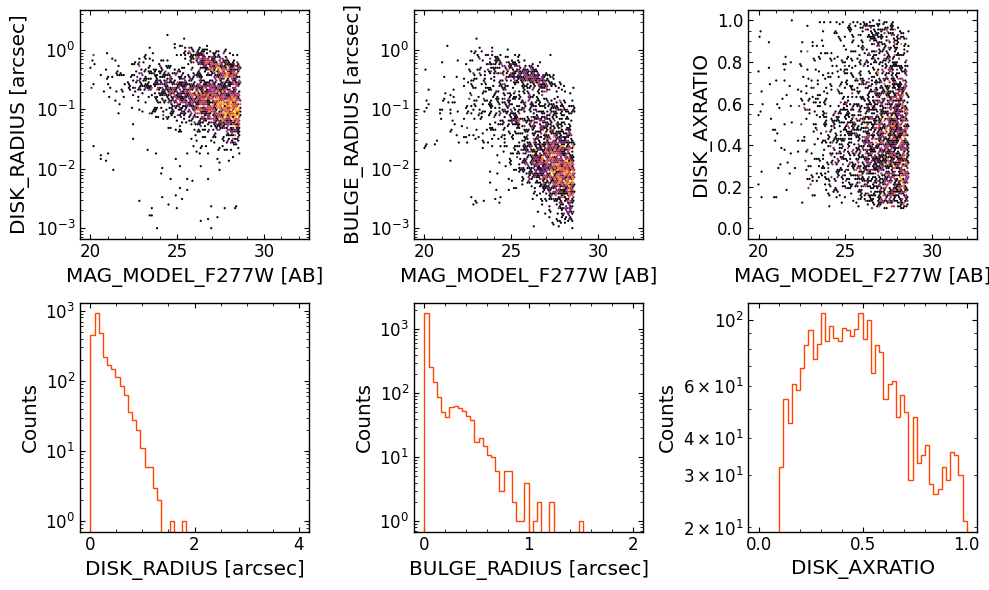

In [29]:
# B+D

plot_BD = tab_BD[tab_BD['flag']==2]

filter = 'f277w'
fig, axs = plt.subplots(2,3, figsize=(10,6))

axs[0,0].hexbin(plot_BD[f'MAG_MODEL_{filter.upper()}'], plot_BD['DISK_RADIUS_deg']*3600, mincnt=1, gridsize=100, cmap='inferno', bins='log', yscale='log', extent=(20,32,-3,0.5), lw=0.01)
axs[0,0].set_xlabel(f"MAG_MODEL_{filter.upper()} [AB]")
axs[0,0].set_ylabel("DISK_RADIUS [arcsec]")

axs[0,1].hexbin(plot_BD[f'MAG_MODEL_{filter.upper()}'], plot_BD['BULGE_RADIUS_deg']*3600, mincnt=1, gridsize=100, cmap='inferno', bins='log', yscale='log', extent=(20,32,-3,0.5), lw=0.01)
axs[0,1].set_xlabel(f"MAG_MODEL_{filter.upper()} [AB]")
axs[0,1].set_ylabel("BULGE_RADIUS [arcsec]")

axs[0,2].hexbin(plot_BD[f'MAG_MODEL_{filter.upper()}'], plot_BD['DISK_AXRATIO'], mincnt=1, gridsize=100, cmap='inferno', bins='log', extent=(20,32,0,1), lw=0.01)
axs[0,2].set_xlabel(f"MAG_MODEL_{filter.upper()} [AB]")
axs[0,2].set_ylabel("DISK_AXRATIO")

axs[1,0].hist(plot_BD['DISK_RADIUS_deg']*3600, bins=50, range=(0,4), histtype='step', log=True, color='orangered')
axs[1,0].set_xlabel("DISK_RADIUS [arcsec]")
axs[1,0].set_ylabel("Counts")

axs[1,1].hist(plot_BD['BULGE_RADIUS_deg']*3600, bins=50, range=(0,2), histtype='step', log=True, color='orangered')
axs[1,1].set_xlabel("BULGE_RADIUS [arcsec]")
axs[1,1].set_ylabel("Counts")

axs[1,2].hist(plot_BD['DISK_AXRATIO'], bins=50, range=(0,1), histtype='step', log=True, color='orangered')
axs[1,2].set_xlabel("DISK_AXRATIO")
axs[1,2].set_ylabel("Counts")

fig.tight_layout()
# fig.savefig(f"{home}/fields/{field}/sepp/{field}-B+D_morphology.pdf", bbox_inches='tight')
# fig.savefig(f"{home}/fields/{field}/sepp/{field}-B+D_morphology.png", bbox_inches='tight', dpi=200)
plt.show()

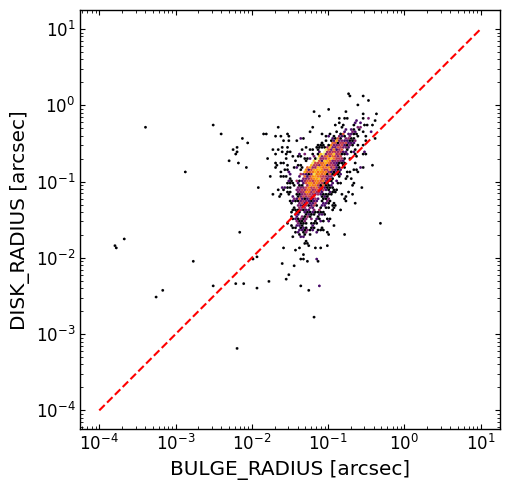

In [47]:
fig, ax = plt.subplots(figsize=(6,5))

ax.hexbin(good_BD['BULGE_RADIUS_deg']*3600, good_BD['DISK_RADIUS_deg']*3600, mincnt=1, gridsize=100, cmap='inferno', bins='log', xscale='log', yscale='log', lw=0.01)
ax.plot([1e-4, 1e1], [1e-4, 1e1], ls='--', c='r')
ax.set_xlabel("BULGE_RADIUS [arcsec]")
ax.set_ylabel("DISK_RADIUS [arcsec]")

ax.set_aspect('equal')

fig.tight_layout()
plt.show()

## UVJ plots

In [48]:
snr_cond = (good_sersic['snrratio']>100) & (good_sersic['MAG_MODEL_F277W']<30)
mass_cond = np.log10(good_dja['mass']) > 10
print(len(good_dja[snr_cond & mass_cond]))

540


/tmp/ipykernel_19495/3702016566.py:2: RuntimeWarning: divide by zero encountered in log10
  mass_cond = np.log10(good_dja['mass']) > 0
/tmp/ipykernel_19495/3702016566.py:2: RuntimeWarning: invalid value encountered in log10
  mass_cond = np.log10(good_dja['mass']) > 0


/tmp/ipykernel_19495/220034178.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=(0,0,1,1))


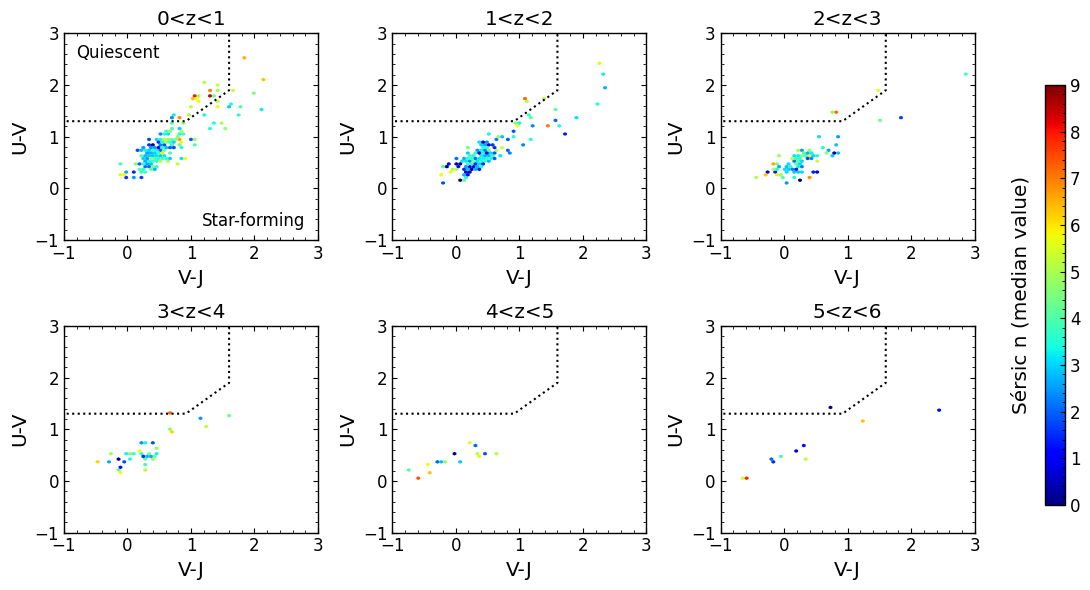

In [36]:
fig, axs = plt.subplots(2,3, figsize=(10,6))

for i in range(6):
    z = (i, i+1)
    ax = axs.flatten()[i]
    z_cond = (good_dja['z_phot']>z[0])&(good_dja['z_phot']<z[1])
    cond = snr_cond & mass_cond & z_cond
    uv = -2.5*np.log10(good_dja[cond]['restU']/good_dja[cond]['restV'])
    vj = -2.5*np.log10(good_dja[cond]['restV']/good_dja[cond]['restJ'])
    ax.plot([-2,0.92,1.6,1.6], [1.3,1.3,1.898,4], ls=':', c='k')
    ax.hexbin(x=vj, y=uv, C=good_sersic[cond]['SERSIC'], reduce_C_function=np.median,
              mincnt=1, gridsize=100, cmap='jet', bins='log', extent=(-2,4,-2,4), lw=0.01, vmax=9)
    ax.set_xlim(-1,3)
    ax.set_ylim(-1,3)
    ax.set_title(f"{z[0]}<z<{z[1]}")
    ax.set_xlabel("V-J")
    ax.set_ylabel("U-V")
    if i==0: ax.text(0.05, 0.95, "Quiescent", transform=ax.transAxes, ha='left', va='top', fontsize='large')
    if i==0: ax.text(0.95, 0.05, "Star-forming", transform=ax.transAxes, ha='right', va='bottom', fontsize='large')

cbar_ax = fig.add_axes([1.05, 0.15, 0.02, 0.7])
norm = mpl.colors.Normalize(vmin=0,vmax=9)
sm = plt.cm.ScalarMappable(cmap=plt.get_cmap('jet'), norm=norm)
sm.set_array([])
cb = fig.colorbar(sm, ticks=np.linspace(0,9,10), cax=cbar_ax, label='Sérsic n (median value)')
cb.set_label("Sérsic n (median value)", labelpad=-50)

fig.tight_layout(rect=(0,0,1,1))
# fig.savefig(f"{home}/fields/{field}/sepp/{field}_UVJ-sersic.pdf", bbox_inches='tight')
# fig.savefig(f"{home}/fields/{field}/sepp/{field}_UVJ-sersic.png", bbox_inches='tight', dpi=200)
plt.show()

/tmp/ipykernel_19495/1178712636.py:16: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=vj[bulge], y=uv[bulge], ax=ax, levels=4, color='r', alpha=0.5)


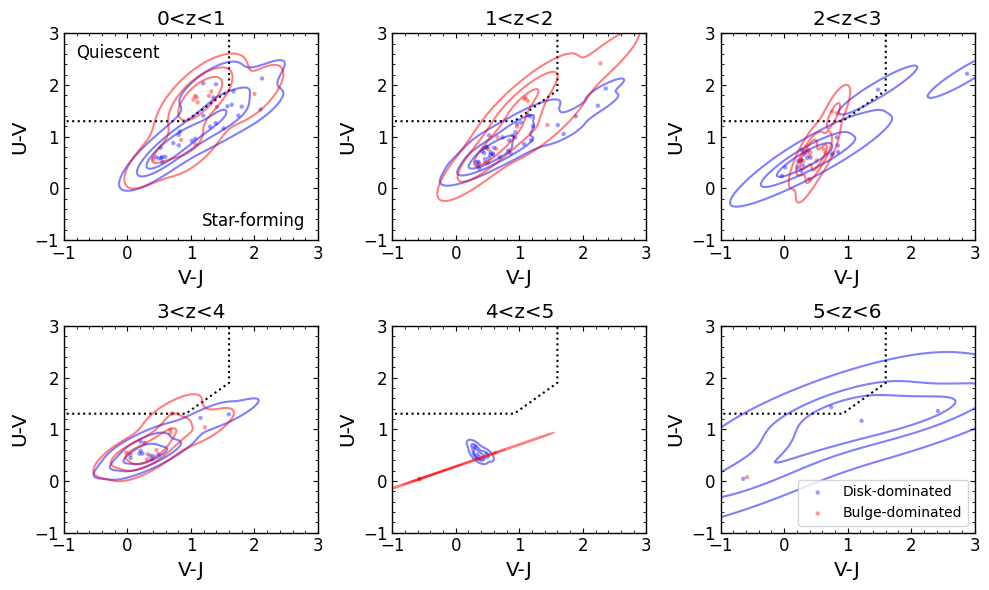

In [33]:
fig, axs = plt.subplots(2,3, figsize=(10,6))

for i in range(6):
    z = (i, i+1)
    ax = axs.flatten()[i]
    z_cond = (good_dja['z_phot']>z[0])&(good_dja['z_phot']<z[1])
    cond = snr_cond & mass_cond & z_cond
    uv = -2.5*np.log10(good_dja[cond]['restU']/good_dja[cond]['restV'])
    vj = -2.5*np.log10(good_dja[cond]['restV']/good_dja[cond]['restJ'])
    disk = (good_sersic[cond]['SERSIC']<4)&(good_BD[cond]['B/T_F200W']<0.4)
    bulge = (good_sersic[cond]['SERSIC']>1)&(good_BD[cond]['B/T_F200W']>0.5)
    ax.plot([-2,0.92,1.6,1.6], [1.3,1.3,1.898,4], ls=':', c='k')
    ax.scatter(vj[disk], uv[disk], c='b', alpha=0.4, s=10, ec='none', label="Disk-dominated")
    sns.kdeplot(x=vj[disk], y=uv[disk], ax=ax, levels=4, color='b', alpha=0.5)
    ax.scatter(vj[bulge], uv[bulge], c='r', alpha=0.4, s=10, ec='none', label="Bulge-dominated")
    sns.kdeplot(x=vj[bulge], y=uv[bulge], ax=ax, levels=4, color='r', alpha=0.5)
    ax.set_xlim(-1,3)
    ax.set_ylim(-1,3)
    ax.set_title(f"{z[0]}<z<{z[1]}")
    ax.set_xlabel("V-J")
    ax.set_ylabel("U-V")
    if i==0: ax.text(0.05, 0.95, "Quiescent", transform=ax.transAxes, ha='left', va='top', fontsize='large')
    if i==0: ax.text(0.95, 0.05, "Star-forming", transform=ax.transAxes, ha='right', va='bottom', fontsize='large')

axs.flatten()[-1].legend(loc='lower right', fontsize='medium')

fig.tight_layout()
# fig.savefig(f"{home}/fields/{field}/sepp/{field}_UVJ-disk-bulge.pdf", bbox_inches='tight')
# fig.savefig(f"{home}/fields/{field}/sepp/{field}_UVJ-disk-bulge.png", bbox_inches='tight', dpi=200)
plt.show()

/tmp/ipykernel_19495/4267279894.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=(0,0,1,1))


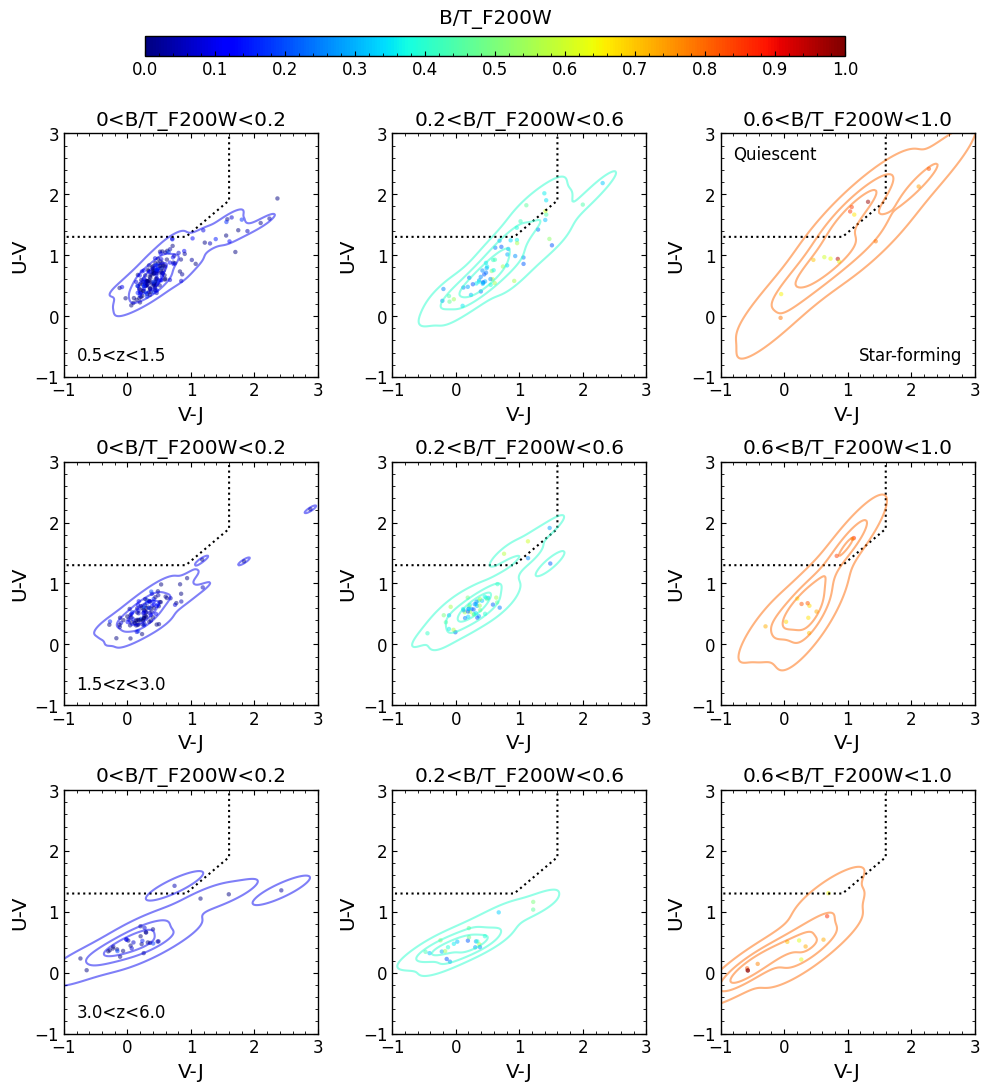

In [49]:
fig, axs = plt.subplots(3,3, figsize=(10,10))

Z = [(0.5,1.5),(1.5,3),(3,6)]
BT = [(0,0.2), (0.2,0.6), (0.6,1.0)]

for i in range(3):
    z = Z[i]
    z_cond = (good_dja['z_phot']>z[0])&(good_dja['z_phot']<z[1])
    for j in range(3):
        ax = axs[i,j]
        bt = BT[j]
        BT_cond = (good_BD['B/T_F200W']>bt[0])&(good_BD['B/T_F200W']<bt[1])
        cond = snr_cond & mass_cond & z_cond & BT_cond
        uv = -2.5*np.log10(good_dja[cond]['restU']/good_dja[cond]['restV'])
        vj = -2.5*np.log10(good_dja[cond]['restV']/good_dja[cond]['restJ'])
        ax.plot([-2,0.92,1.6,1.6], [1.3,1.3,1.898,4], ls=':', c='k')
        ax.scatter(vj, uv, c=good_BD[cond]['B/T_F200W'], alpha=0.5, s=10, ec='none', vmin=0, vmax=1, cmap='jet')
        sns.kdeplot(x=vj, y=uv, ax=ax, levels=4, color=mpl.colormaps.get_cmap('jet')(0.5*(bt[0]+bt[1])), alpha=0.5)
        ax.set_xlim(-1,3)
        ax.set_ylim(-1,3)
        ax.set_title(f"{bt[0]}<B/T_F200W<{bt[1]}")
        ax.set_xlabel("V-J")
        ax.set_ylabel("U-V")
        if j==0: ax.text(0.05, 0.05, f"{z[0]:.1f}<z<{z[1]:.1f}", transform=ax.transAxes, ha='left', va='bottom', fontsize='large')
        if (i==0)&(j==2): ax.text(0.05, 0.95, "Quiescent", transform=ax.transAxes, ha='left', va='top', fontsize='large')
        if (i==0)&(j==2): ax.text(0.95, 0.05, "Star-forming", transform=ax.transAxes, ha='right', va='bottom', fontsize='large')

cbar_ax = fig.add_axes([0.15, 1.04, 0.7, 0.02])
norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=plt.get_cmap('jet'), norm=norm)
sm.set_array([])
cb = fig.colorbar(sm, orientation='horizontal', ticks=np.linspace(0,1,11), cax=cbar_ax)
cb.set_label("B/T_F200W", labelpad=-50)

fig.tight_layout(rect=(0,0,1,1))
# fig.savefig(f"{home}/fields/{field}/sepp/{field}_UVJ-BT.pdf", bbox_inches='tight')
# fig.savefig(f"{home}/fields/{field}/sepp/{field}_UVJ-BT.png", bbox_inches='tight', dpi=200)
plt.show()

## Size evolution

https://arxiv.org/pdf/2309.04377

In [15]:
# Selection
snr_cond = (good_sersic['snrratio']>100) & (good_sersic['MAG_MODEL_F277W']<28)
mass_cond = good_dja['mass'] > np.power(10, 9.5)
rad_cond = good_sersic['RADIUS']>2e-6

cond = snr_cond & mass_cond & rad_cond
print(len(good_dja[cond]))

176


In [16]:
z = good_dja[cond]['z_phot']

z_bins = [0,1,2,3,4,6,8]

/home/aurelien/miniforge3/envs/dawn/lib/python3.9/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/aurelien/miniforge3/envs/dawn/lib/python3.9/site-packages/astropy/stats/sigma_clipping.py:1030: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(data_clipped, axis=axis)
/home/aurelien/miniforge3/envs/dawn/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/aurelien/miniforge3/envs/dawn/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/aurelien/miniforge3/envs/dawn/lib/python3.9/site-packages/astropy/stats/sigma_clipping.py:1030: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(data_clipped, axis=axis)
/home/aurelien/m

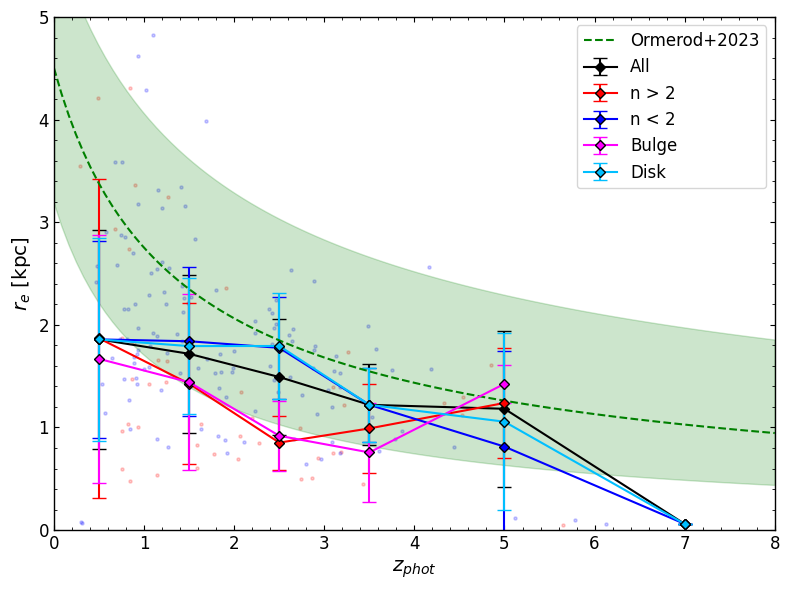

In [17]:
def scatter_bin(x, y, x_bins, color, ax, label=None, scatter=True):
    x_center = 0.5*(x_bins+np.roll(x_bins, -1))[:-1]
    sigma = np.array([sigma_clipped_stats(y[(x>=x_bins[i])&(x<x_bins[i+1])]) for i in range(len(x_bins)-1)])
    if scatter: ax.scatter(x, y, c=color, s=5, alpha=0.2)
    ax.errorbar(x_center, sigma[:,1], yerr=sigma[:,2], color=color, mec='k', capsize=5, ms=5, marker='D', label=label)

radius = (cosmo.kpc_proper_per_arcmin(good_dja['z_phot'])*good_sersic['RADIUS']*u.deg)[cond].to(u.kpc).value

fig, ax = plt.subplots(1,1, figsize=(8,6))

disk = (good_sersic[cond]['SERSIC']<4)&(good_BD[cond]['B/T_F200W']<0.4)
bulge = (good_sersic[cond]['SERSIC']>1)&(good_BD[cond]['B/T_F200W']>0.5)

scatter_bin(z, radius, z_bins, color='k', ax=ax, scatter=False, label='All')
scatter_bin(z[good_sersic[cond]['SERSIC']>2], radius[good_sersic[cond]['SERSIC']>2], z_bins, color='r', ax=ax, label='n > 2', scatter=True)
scatter_bin(z[good_sersic[cond]['SERSIC']<2], radius[good_sersic[cond]['SERSIC']<2], z_bins, color='b', ax=ax, label='n < 2', scatter=True)
scatter_bin(z[bulge], radius[bulge], z_bins, color='magenta', ax=ax, label='Bulge', scatter=False)
scatter_bin(z[disk], radius[disk], z_bins, color='deepskyblue', ax=ax, label='Disk', scatter=False)

# Ormerod+2023
z_lin = np.linspace(z_bins[0], z_bins[-1], 100)
ax.plot(z_lin, 4.5*np.power(1+z_lin, -0.71), ls='--', c='green', label='Ormerod+2023')
ax.fill_between(z_lin, (4.5+1.32)*np.power(1+z_lin, -0.71+0.19), (4.5-1.32)*np.power(1+z_lin, -0.71-0.19), color='g', alpha=0.2)

ax.set_xlabel(r"$z_{phot}$")
ax.set_ylabel(r"$r_e$ [kpc]")
ax.legend()

ax.set_xlim(z_bins[0], z_bins[-1])
ax.set_ylim(0,5)

fig.tight_layout()
# fig.savefig(f"{home}/fields/{field}/sepp/{field}_size-evolution.pdf", bbox_inches='tight')
# fig.savefig(f"{home}/fields/{field}/sepp/{field}_size-evolution.png", bbox_inches='tight', dpi=200)
plt.show()

/home/aurelien/miniforge3/envs/dawn/lib/python3.9/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/aurelien/miniforge3/envs/dawn/lib/python3.9/site-packages/astropy/stats/sigma_clipping.py:1030: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(data_clipped, axis=axis)
/home/aurelien/miniforge3/envs/dawn/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/aurelien/miniforge3/envs/dawn/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/aurelien/miniforge3/envs/dawn/lib/python3.9/site-packages/astropy/stats/sigma_clipping.py:1030: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(data_clipped, axis=axis)
/home/aurelien/m

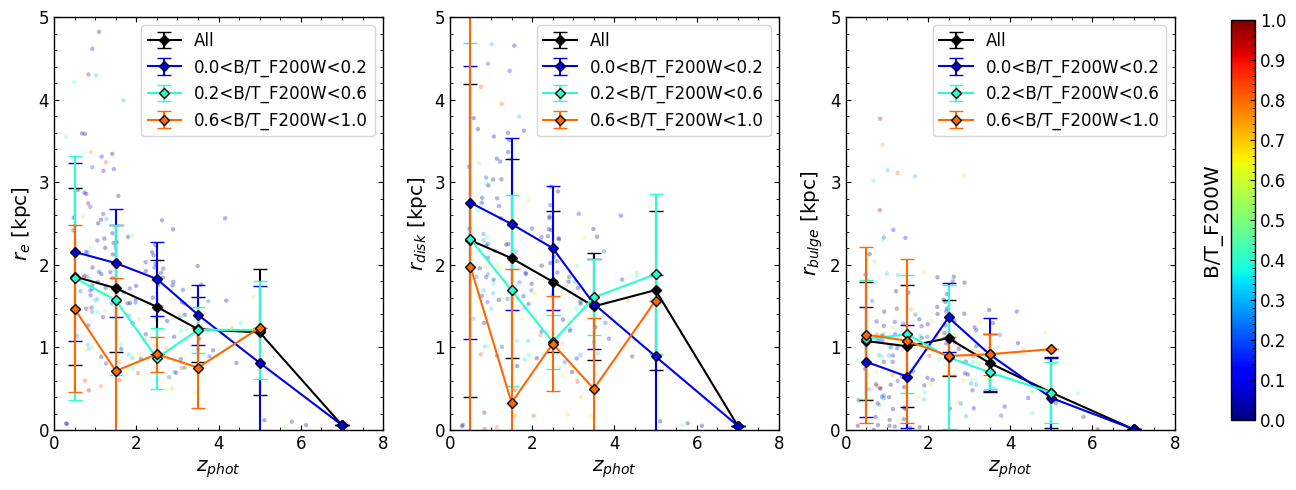

In [18]:
fig, axs = plt.subplots(1,3, figsize=(12,5))

RAD = [good_sersic['RADIUS'], good_BD['DISK_RADIUS_deg'], good_BD['BULGE_RADIUS_deg']]
RAD_NAME = [r"$r_e$ [kpc]", r"$r_{disk}$ [kpc]", r"$r_{bulge}$ [kpc]"]

for j, ax in enumerate(axs):
    radius = (cosmo.kpc_proper_per_arcmin(good_dja['z_phot'])*RAD[j]*u.deg)[cond].to(u.kpc).value
    ax.scatter(z, radius, c=good_BD[cond]['B/T_F200W'], alpha=0.3, s=10, ec='none', vmin=0, vmax=1, cmap='jet')
    scatter_bin(z, radius, z_bins, color='k', ax=ax, label='All', scatter=False)
    BT = [(0.0,0.2), (0.2,0.6), (0.6,1.0)]
    for i in range(len(BT)):
        bt = BT[i]
        bt_cond = (good_BD[cond]['B/T_F200W']>bt[0])&(good_BD[cond]['B/T_F200W']<bt[1])
        scatter_bin(z[bt_cond], radius[bt_cond], z_bins, 
                    color=mpl.colormaps.get_cmap('jet')(0.5*(bt[0]+bt[1])), ax=ax, 
                    label=f"{bt[0]:.1f}<B/T_F200W<{bt[1]:.1f}", scatter=False)
    ax.set_xlabel(r"$z_{phot}$")
    ax.set_ylabel(RAD_NAME[j])
    ax.legend()
    ax.set_xlim(z_bins[0], z_bins[-1])
    ax.set_ylim(0,5)

# Ormerod+2023
# z_lin = np.linspace(z_bins[0], z_bins[-1], 100)
# ax.plot(z_lin, 4.5*np.power(1+z_lin, -0.71), ls='--', c='green', label='Ormerod+2023')
# ax.fill_between(z_lin, (4.5+1.32)*np.power(1+z_lin, -0.71+0.19), (4.5-1.32)*np.power(1+z_lin, -0.71-0.19), color='g', alpha=0.2)

cbar_ax = fig.add_axes([1.03, 0.15, 0.02, 0.8])
norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=plt.get_cmap('jet'), norm=norm)
sm.set_array([])
cb = fig.colorbar(sm, orientation='vertical', ticks=np.linspace(0,1,11), cax=cbar_ax)
cb.set_label("B/T_F200W", labelpad=-60)

fig.tight_layout()
# fig.savefig(f"{home}/fields/{field}/sepp/{field}_size-evolution_complete.pdf", bbox_inches='tight')
# fig.savefig(f"{home}/fields/{field}/sepp/{field}_size-evolution_complete.png", bbox_inches='tight', dpi=200)
plt.show()